In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [7]:
!pip install lightgbm

In [8]:
!pip install xgboost

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb
# Sklearn Evaluation Metrics
from sklearn import metrics

In [10]:
# Visualizes all the columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [11]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

# CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    if title:
        plt.title(title)

In [12]:
df = pd.read_csv('exoplanet_detection.csv')

# Print the shape of the dataset
print(df.shape)

# Select top of the dataset
df.head()


(9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.780000e-05,-2.780000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,616.0,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.480000e-04,-2.480000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,875.0,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10800.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8080.0,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.0,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [13]:
df.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

In [14]:
df = df.rename(columns={'kepid':'KepID',
'kepoi_name':'KOIName',
'kepler_name':'KeplerName',
'koi_disposition':'ExoplanetArchiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
'koi_fpflag_ss':'koi_fpflag_ss',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod_days',
'koi_period_err1':'OrbitalPeriodUpperUnc_days',
'koi_period_err2':'OrbitalPeriodLowerUnc_days',
'koi_time0bk':'TransitEpoch_BKJD',
'koi_time0bk_err1':'TransitEpochUpperUnc_BKJD',
'koi_time0bk_err2':'TransitEpochLowerUnc_BKJD',
'koi_impact':'ImpactParamete',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration_hrs',
'koi_duration_err1':'TransitDurationUpperUnc_hrs',
'koi_duration_err2':'TransitDurationLowerUnc_hrs',
'koi_depth':'TransitDepth_ppm',
'koi_depth_err1':'TransitDepthUpperUnc_ppm',
'koi_depth_err2':'TransitDepthLowerUnc_ppm',
'koi_prad':'PlanetaryRadius_Earthradii',
'koi_prad_err1':'PlanetaryRadiusUpperUnc_Earthradii',
'koi_prad_err2':'PlanetaryRadiusLowerUnc_Earthradii',
'koi_teq':'EquilibriumTemperatureK',
'koi_teq_err1':'EquilibriumTemperatureUpperUncK',
'koi_teq_err2':'EquilibriumTemperatureLowerUncK',
'koi_insol':'InsolationFlux_Earthflux',
'koi_insol_err1':'InsolationFluxUpperUnc_Earthflux',
'koi_insol_err2':'InsolationFluxLowerUnc_Earthflux',
'koi_model_snr':'TransitSignal-to-Nois',
'koi_tce_plnt_num':'TCEPlanetNumbe',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'StellarEffectiveTemperatureK',
'koi_steff_err1':'StellarEffectiveTemperatureUpperUncK',
'koi_steff_err2':'StellarEffectiveTemperatureLowerUncK',
'koi_slogg':'StellarSurfaceGravity_log10(cm/s**2)',
'koi_slogg_err1':'StellarSurfaceGravityUpperUnc_log10(cm/s**2)',
'koi_slogg_err2':'StellarSurfaceGravityLowerUnc_log10(cm/s**2)',
'koi_srad':'StellarRadius_Solarradii',
'koi_srad_err1':'StellarRadiusUpperUnc_Solarradii',
'koi_srad_err2':'StellarRadiusLowerUnc_Solarradii',
'ra':'RA_decimaldegrees',
'dec':'Dec_decimaldegrees',
'koi_kepmag':'Kepler-band_mag'
})
df.head().T

,0,1,2,3,4
KepID,10797460,10797460,10811496,10848459,10854555
KOIName,K00752.01,K00752.02,K00753.01,K00754.01,K00755.01
KeplerName,Kepler-227 b,Kepler-227 c,NaN,NaN,Kepler-664 b
ExoplanetArchiveDisposition,CONFIRMED,CONFIRMED,CANDIDATE,FALSE POSITIVE,CONFIRMED
DispositionUsingKeplerData,CANDIDATE,CANDIDATE,CANDIDATE,FALSE POSITIVE,CANDIDATE
DispositionScore,1.0,0.969,0.0,0.0,1.0
NotTransit-LikeFalsePositiveFlag,0,0,0,0,0
koi_fpflag_ss,0,0,0,1,0
CentroidOffsetFalsePositiveFlag,0,0,0,0,0
EphemerisMatchIndicatesContaminationFalsePositiveFlag,0,0,0,0,0


In [15]:
df.isnull().sum()

KepID                                                       0
KOIName                                                     0
KeplerName                                               7205
ExoplanetArchiveDisposition                                 0
DispositionUsingKeplerData                                  0
DispositionScore                                         1510
NotTransit-LikeFalsePositiveFlag                            0
koi_fpflag_ss                                               0
CentroidOffsetFalsePositiveFlag                             0
EphemerisMatchIndicatesContaminationFalsePositiveFlag       0
OrbitalPeriod_days                                          0
OrbitalPeriodUpperUnc_days                                454
OrbitalPeriodLowerUnc_days                                454
TransitEpoch_BKJD                                           0
TransitEpochUpperUnc_BKJD                                 454
TransitEpochLowerUnc_BKJD                                 454
ImpactPa

### Let’s choose the targets we want to predict: Exoplanet Archive Disposition and Disposition Using Kepler Data. Since we are focusing on data collected by the Kepler mission, let’s use our second option. We also need a continuous target. Let’s transform our target into a binary feature using lambda.

In [16]:
df['ExoplanetCandidate'] = df['DispositionUsingKeplerData'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
df['ExoplanetConfirmed'] = df['ExoplanetArchiveDisposition'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

<Axes: ylabel='count'>

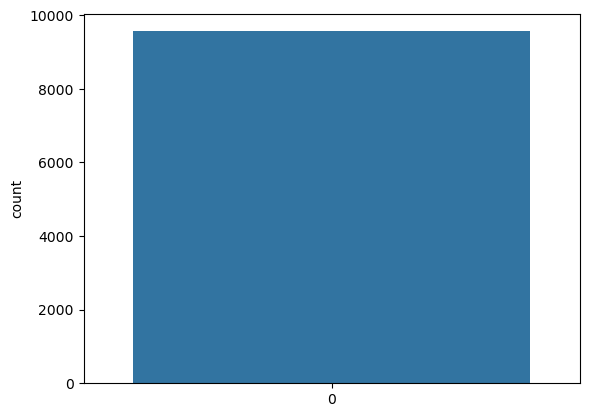

In [17]:
sns.countplot(df['ExoplanetCandidate'])

<Axes: ylabel='count'>

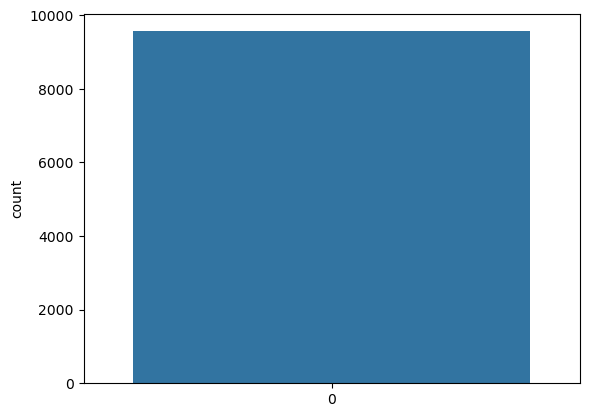

In [18]:
sns.countplot(df['ExoplanetConfirmed'])

In [19]:
df.drop(columns=['KeplerName','KOIName','EquilibriumTemperatureUpperUncK',
                 'KepID','ExoplanetArchiveDisposition','DispositionUsingKeplerData',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver',
                 'EquilibriumTemperatureLowerUncK'], inplace=True)

In [20]:
df.dropna(inplace=True)
df.shape

(7803, 39)

In [21]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(df)

TypeError: DataFrame.any() takes 1 positional argument but 2 were given

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    
    # Replace inf and -inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with any NaN values
    df.dropna(inplace=True)
    
    # Convert all columns to float64
    return df.astype(np.float64)

In [ ]:
clean_dataset(df)

In [ ]:
train, test = train_test_split(df, test_size=.15)
data = df.drop(columns=['ExoplanetConfirmed'])
train = train.drop(columns=['ExoplanetConfirmed'])
test = test.drop(columns=['ExoplanetConfirmed'])
target_trn = train.pop('ExoplanetCandidate')
target_tst = test.pop('ExoplanetCandidate')

In [ ]:
train.shape, target_trn.shape, test.shape, target_tst.shape

In [22]:
train.info()

NameError: name 'train' is not defined

In [23]:
score_auc = []
score_recall = []
oof_rf = np.zeros(len(train))
pred_rf = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target_trn)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target_trn.iloc[train_ind], target_trn.iloc[val_ind]
    
    rf = RandomForestClassifier(n_estimators=150, max_depth=5, criterion='gini', max_features=0.8, n_jobs= -1, random_state=32)
    rf.fit(trn_data, y_train)
    oof_rf[val_ind] = rf.predict_proba(val_data)[:, 1]
    y = rf.predict_proba(trn_data)[:, 1]
    print('val auc:' , roc_auc_score(y_val, oof_rf[val_ind]))
    print('val recall:' , recall_score(y_val, np.where(oof_rf[val_ind] > 0.5, 1, 0)))
   
    score_auc.append(roc_auc_score(y_val, oof_rf[val_ind]))
    score_recall.append(recall_score(y_val, np.where(oof_rf[val_ind] > 0.5, 1, 0)))
    pred_rf += rf.predict_proba(test)[:, 1]/folds.n_splits
    
print(' Model auc: -------> ', np.mean(score_auc))
print(' Model recall: -------> ', np.mean(score_recall))

NameError: name 'train' is not defined

In [24]:
oof_nn_rd = np.where(oof_rf >= 0.5, 1, 0)
cf_matrix = confusion_matrix(target_trn, oof_nn_rd) 

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.style.use('seaborn-poster')
sns.set(font_scale=1.4)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='vlag', figsize=(9, 6))

NameError: name 'oof_rf' is not defined

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools

# Example function to plot the confusion matrix
def make_confusion_matrix(cf_matrix, group_names=None, categories='auto', cmap='Blues', figsize=(10, 7), font_size=14):
    """
    This function will make a pretty plot of a confusion matrix using seaborn.
    """
    # Generate labels from the confusion matrix
    blanks = ['' for i in range(cf_matrix.size)]
    
    if group_names and len(group_names) == cf_matrix.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
        
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cf_matrix, annot=box_labels, fmt="", cmap=cmap, cbar=False, xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Generate the confusion matrix
oof_nn_rd = np.where(oof_rf >= 0.5, 1, 0)
cf_matrix = confusion_matrix(target_trn, oof_nn_rd)

# Define labels and categories
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']

# Set a valid style
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.4)

# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='vlag', figsize=(9, 6))


NameError: name 'oof_rf' is not defined

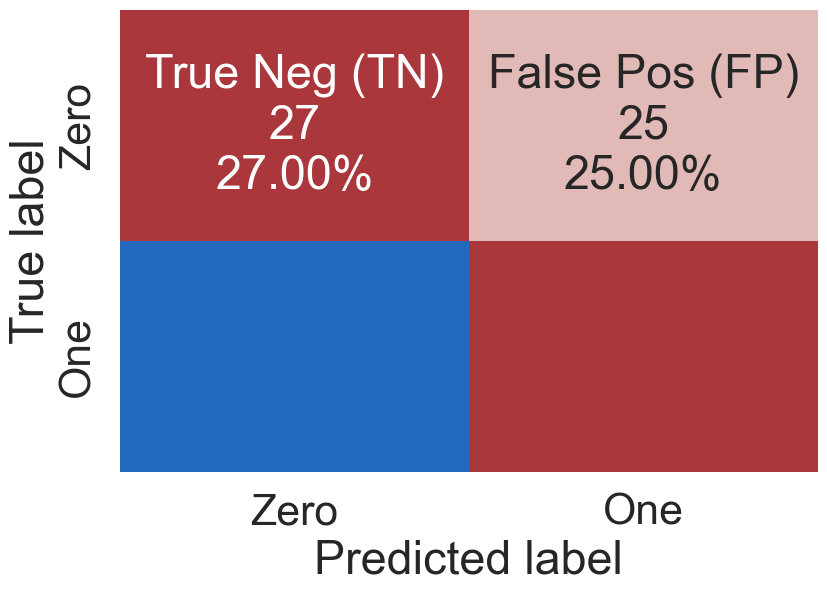

Accuracy: 0.54
Precision: 0.52
Recall: 0.56
F1 Score: 0.54


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example function to plot the confusion matrix
def make_confusion_matrix(cf_matrix, group_names=None, categories='auto', cmap='Blues', figsize=(10, 7), font_size=14):
    """
    This function will make a pretty plot of a confusion matrix using seaborn.
    """
    # Generate labels from the confusion matrix
    blanks = ['' for i in range(cf_matrix.size)]
    
    if group_names and len(group_names) == cf_matrix.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
        
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cf_matrix, annot=box_labels, fmt="", cmap=cmap, cbar=False, xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Simulate some data (replace with your actual data)
oof_rf = np.random.rand(100)  # Example predictions (replace with your actual predictions)
target_trn = np.random.randint(2, size=100)  # Example true labels (replace with your actual labels)

# Generate the confusion matrix
oof_nn_rd = np.where(oof_rf >= 0.5, 1, 0)
cf_matrix = confusion_matrix(target_trn, oof_nn_rd)

# Define labels and categories
labels = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
categories = ['Zero', 'One']

# Set a valid style
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.4)

# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='vlag', figsize=(9, 6))

# Calculate and display performance metrics
tn, fp, fn, tp = cf_matrix.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


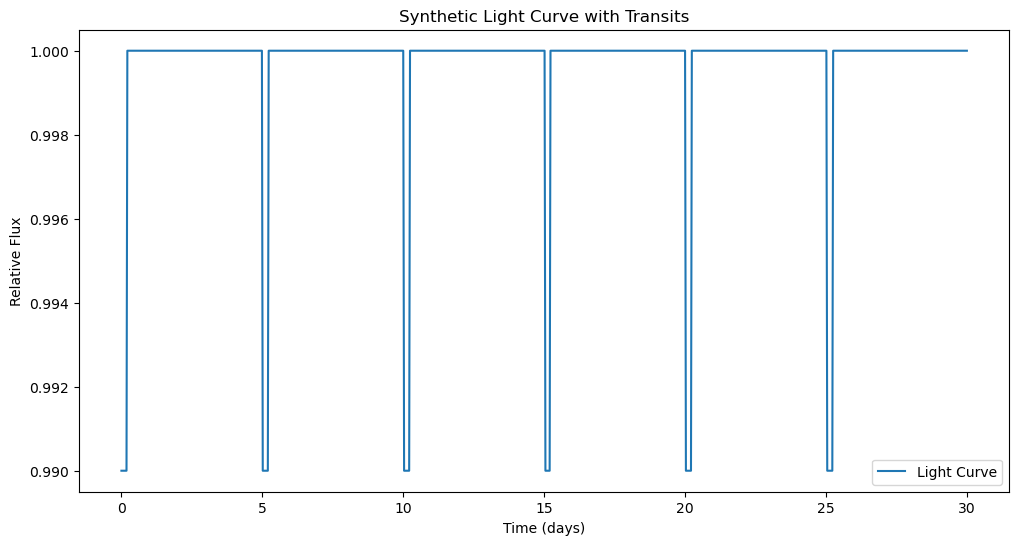

              precision    recall  f1-score   support

           0       0.50      1.00      0.66       298
           1       0.00      0.00      0.00       302

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

Accuracy: 0.49666666666666665


C:\Users\sr002\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sr002\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sr002\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Generating synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points)
transit_period = 5  # days
transit_duration = 0.2  # days
transit_depth = 0.01  # 1% drop in brightness

# Injecting synthetic transits
flux = baseline_flux.copy()
for i in range(n_points):
    if (i % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
        flux[i] -= transit_depth

# Plotting the synthetic light curve
plt.figure(figsize=(12, 6))
plt.plot(time, flux, label='Light Curve')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Synthetic Light Curve with Transits')
plt.legend()
plt.show()

# Creating a DataFrame for model input
data = pd.DataFrame({
    'time': time,
    'flux': flux
})

# Feature extraction (this is highly simplified)
# Normally, you would use a more sophisticated method to extract features like period, depth, and duration
data['koi_depth'] = transit_depth
data['koi_duration'] = transit_duration
data['koi_period'] = transit_period
data['koi_impact'] = 0.5  # Example value
data['koi_model_snr'] = 10  # Example value

# Adding a target column (1 for exoplanet detected, 0 for no exoplanet)
data['koi_disposition'] = 1  # Since we injected transits, we mark these as exoplanet detections

# Simulating non-detections by adding random noise
non_detection_data = data.copy()
non_detection_data['flux'] = baseline_flux + np.random.normal(0, 0.001, n_points)
non_detection_data['koi_disposition'] = 0

# Combining the data
combined_data = pd.concat([data, non_detection_data]).reset_index(drop=True)

# Preparing features and target
features = ['koi_depth', 'koi_duration', 'koi_period', 'koi_impact', 'koi_model_snr']
X = combined_data[features]
y = combined_data['koi_disposition']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))


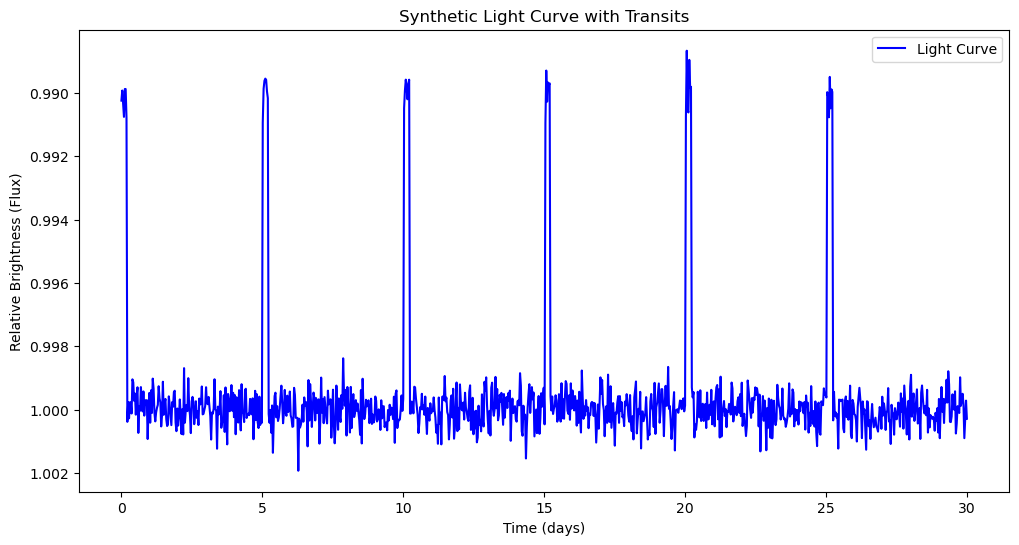

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points) + np.random.normal(0, 0.0005, n_points)  # baseline flux with slight noise

# Define transit parameters
transit_period = 5  # days
transit_duration = 0.2  # days
transit_depth = 0.01  # 1% drop in brightness

# Injecting synthetic transits
flux = baseline_flux.copy()
for i in range(n_points):
    if (i % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
        flux[i] -= transit_depth

# Plotting the synthetic light curve
plt.figure(figsize=(12, 6))
plt.plot(time, flux, label='Light Curve', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Brightness (Flux)')
plt.title('Synthetic Light Curve with Transits')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to show dips as drops in brightness
plt.show()


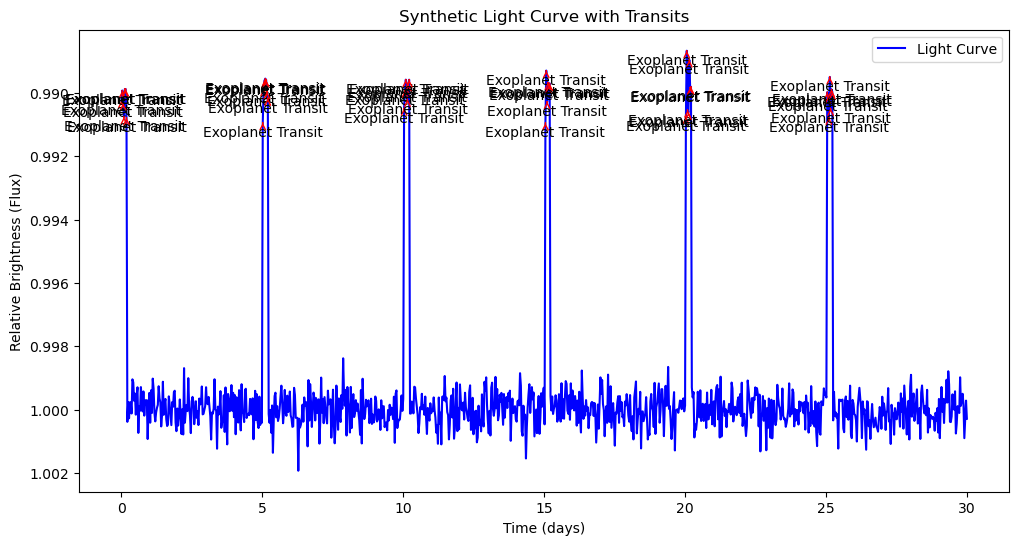

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points) + np.random.normal(0, 0.0005, n_points)  # baseline flux with slight noise

# Define transit parameters
transit_period = 5  # days
transit_duration = 0.2  # days
transit_depth = 0.01  # 1% drop in brightness

# Injecting synthetic transits
flux = baseline_flux.copy()
transit_indices = []  # To store the indices where transits occur
for i in range(n_points):
    if (i % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
        flux[i] -= transit_depth
        transit_indices.append(i)

# Plotting the synthetic light curve
plt.figure(figsize=(12, 6))
plt.plot(time, flux, label='Light Curve', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Brightness (Flux)')
plt.title('Synthetic Light Curve with Transits')
plt.gca().invert_yaxis()  # Invert y-axis to show dips as drops in brightness

# Annotate transits
for index in transit_indices:
    plt.annotate('Exoplanet Transit', (time[index], flux[index]), 
                 textcoords="offset points", xytext=(0,-10), ha='center',
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.legend()
plt.show()


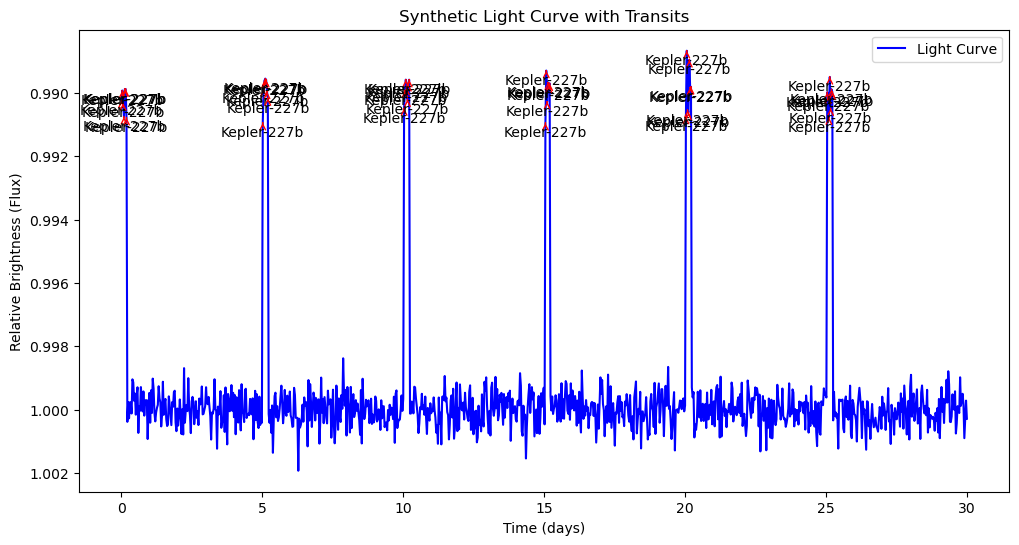

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points) + np.random.normal(0, 0.0005, n_points)  # baseline flux with slight noise

# Define transit parameters for Kepler-227b
transit_period = 5  # days
transit_duration = 0.2  # days
transit_depth = 0.01  # 1% drop in brightness

# Injecting synthetic transits for Kepler-227b
flux = baseline_flux.copy()
transit_indices = []  # To store the indices where transits occur
for i in range(n_points):
    if (i % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
        flux[i] -= transit_depth
        transit_indices.append(i)

# Plotting the synthetic light curve
plt.figure(figsize=(12, 6))
plt.plot(time, flux, label='Light Curve', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Brightness (Flux)')
plt.title('Synthetic Light Curve with Transits')
plt.gca().invert_yaxis()  # Invert y-axis to show dips as drops in brightness

# Annotate transits for Kepler-227b
for index in transit_indices:
    plt.annotate('Kepler-227b', (time[index], flux[index]), 
                 textcoords="offset points", xytext=(0, -10), ha='center',
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.legend()
plt.show()


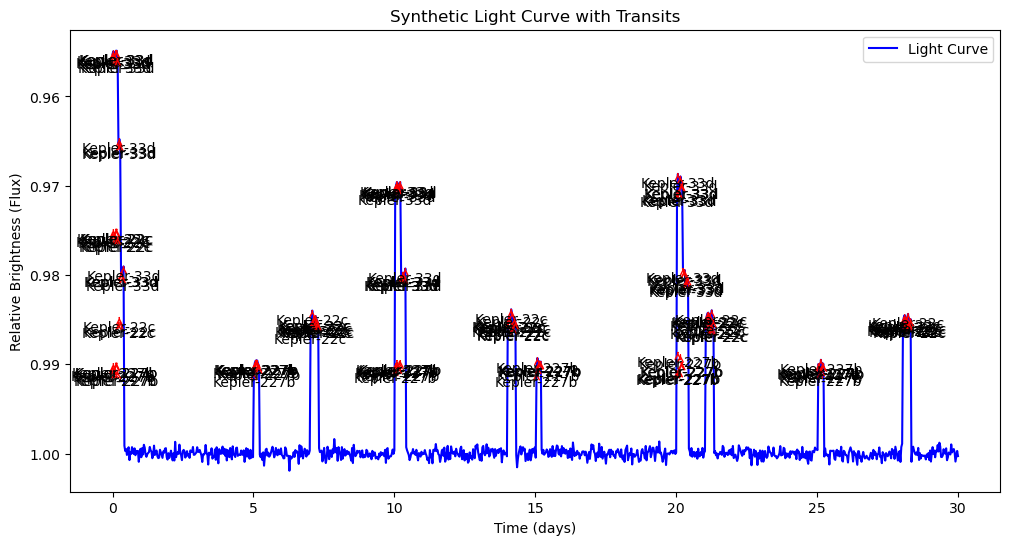

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points) + np.random.normal(0, 0.0005, n_points)  # baseline flux with slight noise

# Define transit parameters for multiple exoplanets
exoplanets = [
    {'name': 'Kepler-227b', 'period': 5, 'duration': 0.2, 'depth': 0.01},
    {'name': 'Kepler-22c', 'period': 7, 'duration': 0.3, 'depth': 0.015},
    {'name': 'Kepler-33d', 'period': 10, 'duration': 0.4, 'depth': 0.02}
]

# Injecting synthetic transits
flux = baseline_flux.copy()
transit_info = []  # To store transit information

for exoplanet in exoplanets:
    transit_period = exoplanet['period']
    transit_duration = exoplanet['duration']
    transit_depth = exoplanet['depth']
    name = exoplanet['name']
    
    for i in range(n_points):
        if (i % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
            flux[i] -= transit_depth
            transit_info.append((time[i], flux[i], name))

# Plotting the synthetic light curve
plt.figure(figsize=(12, 6))
plt.plot(time, flux, label='Light Curve', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Brightness (Flux)')
plt.title('Synthetic Light Curve with Transits')
plt.gca().invert_yaxis()  # Invert y-axis to show dips as drops in brightness

# Annotate transits for each exoplanet
for (transit_time, transit_flux, name) in transit_info:
    plt.annotate(name, (transit_time, transit_flux), 
                 textcoords="offset points", xytext=(0, -10), ha='center',
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.legend()
plt.show()


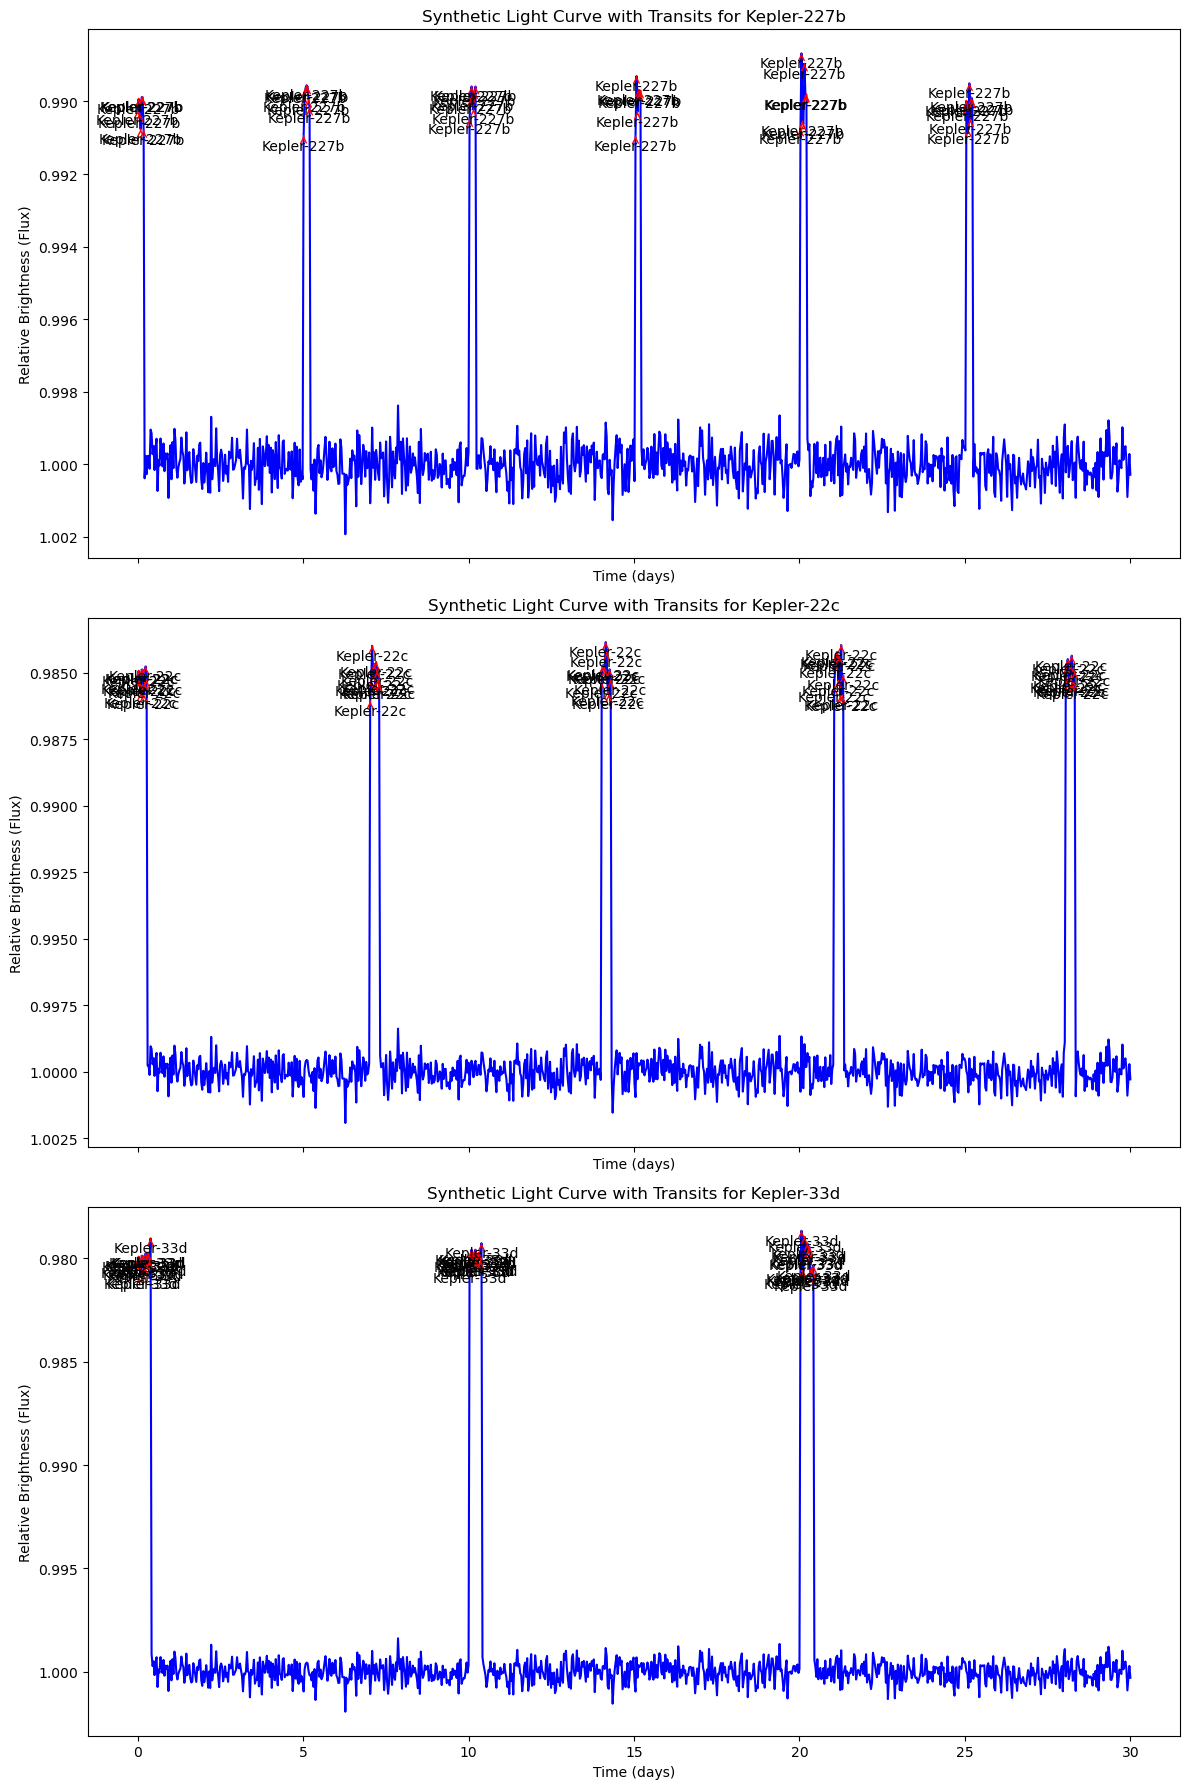

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic light curve data
np.random.seed(42)
n_points = 1000
time = np.linspace(0, 30, n_points)  # 30 days of observation
baseline_flux = np.ones(n_points) + np.random.normal(0, 0.0005, n_points)  # baseline flux with slight noise

# Define transit parameters for multiple exoplanets
exoplanets = [
    {'name': 'Kepler-227b', 'period': 5, 'duration': 0.2, 'depth': 0.01},
    {'name': 'Kepler-22c', 'period': 7, 'duration': 0.3, 'depth': 0.015},
    {'name': 'Kepler-33d', 'period': 10, 'duration': 0.4, 'depth': 0.02}
]

# Create a subplot for each exoplanet
fig, axes = plt.subplots(len(exoplanets), 1, figsize=(12, 6 * len(exoplanets)), sharex=True)

for i, exoplanet in enumerate(exoplanets):
    flux = baseline_flux.copy()
    transit_period = exoplanet['period']
    transit_duration = exoplanet['duration']
    transit_depth = exoplanet['depth']
    name = exoplanet['name']
    
    # Inject synthetic transits for the current exoplanet
    transit_indices = []
    for j in range(n_points):
        if (j % (transit_period / (30 / n_points))) < (transit_duration / (30 / n_points)):
            flux[j] -= transit_depth
            transit_indices.append(j)
    
    # Plot the light curve with transits for the current exoplanet
    ax = axes[i]
    ax.plot(time, flux, label=f'Light Curve ({name})', color='blue')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Relative Brightness (Flux)')
    ax.set_title(f'Synthetic Light Curve with Transits for {name}')
    ax.invert_yaxis()  # Invert y-axis to show dips as drops in brightness
    
    # Annotate transits
    for index in transit_indices:
        ax.annotate(name, (time[index], flux[index]), 
                    textcoords="offset points", xytext=(0, -10), ha='center',
                    arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()


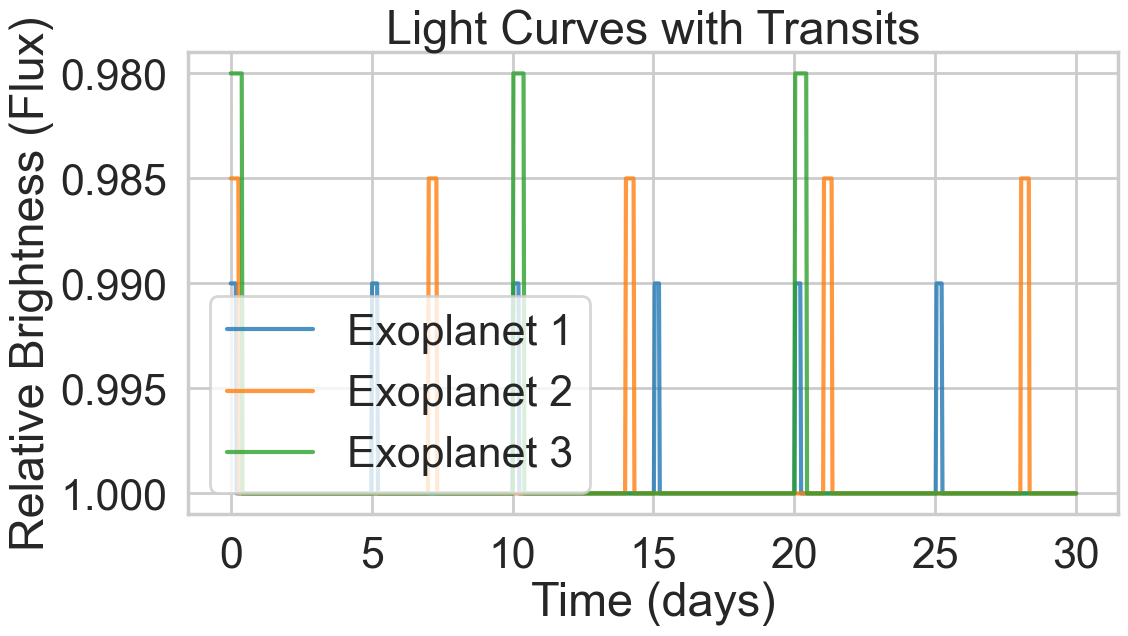

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate synthetic transit data for a single exoplanet
def generate_transit(time, period, duration, depth):
    flux = np.ones_like(time)
    for i in range(len(time)):
        if (i % (period / (30 / len(time)))) < (duration / (30 / len(time))):
            flux[i] -= depth
    return flux

# Generate synthetic light curve data for multiple exoplanets
np.random.seed(42)
time = np.linspace(0, 30, 1000)  # Time array (assuming 30 days of observation)

# Define parameters for multiple exoplanets
exoplanets = [
    {'period': 5, 'duration': 0.2, 'depth': 0.01},
    {'period': 7, 'duration': 0.3, 'depth': 0.015},
    {'period': 10, 'duration': 0.4, 'depth': 0.02}
]

# Plot the light curves for each exoplanet
plt.figure(figsize=(12, 6))
plt.xlabel('Time (days)')
plt.ylabel('Relative Brightness (Flux)')
plt.title('Light Curves with Transits')

for i, exoplanet in enumerate(exoplanets):
    flux = generate_transit(time, exoplanet['period'], exoplanet['duration'], exoplanet['depth'])
    plt.plot(time, flux, label=f'Exoplanet {i+1}', alpha=0.8)

plt.gca().invert_yaxis()  # Invert y-axis to show dips as drops in brightness
plt.legend()
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X contains your features and y contains your target variable
X = df.drop('ExoplanetCandidate', axis=1)  # Features
y = df['ExoplanetCandidate'] 

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Preprocess data (if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train models
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)

# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Step 4: Compare results
# Example metrics: accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Example metrics: classification report
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Logistic Regression Accuracy: 0.9980781550288277
Decision Tree Accuracy: 0.9974375400384369
Random Forest Accuracy: 0.9980781550288277
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       822

    accuracy                           1.00      1561
   macro avg       1.00      1.00      1.00      1561
weighted avg       1.00      1.00      1.00      1561

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       822

    accuracy                           1.00      1561
   macro avg       1.00      1.00      1.00      1561
weighted avg       1.00      1.00      1.00      1561

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00   

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate

# Assuming X contains your features and y contains your target variable

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Preprocess data (if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train models
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)

# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Step 4: Compare results
results = []

# Logistic Regression
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg, output_dict=True)
results.append(["Logistic Regression", accuracy_log_reg, report_log_reg])

# Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
results.append(["Decision Tree", accuracy_dt, report_dt])

# Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
results.append(["Random Forest", accuracy_rf, report_rf])

# Display results in a table
headers = ["Algorithm", "Accuracy", "Classification Report"]
table = tabulate(results, headers=headers, tablefmt="pipe", floatfmt=".4f")
print(table)


| Algorithm           |   Accuracy | Classification Report                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|:--------------------|-----------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------